In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import os

np.random.seed(42)

def load_data(crashes_filtered_path="crashes_filtered.csv"):
    path = os.path.join(crashes_filtered_path)
    return pd.read_csv(path)

crashes_filtered = load_data()
# crashes_filtered.head(5)

In [ ]:
crashes_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44679 entries, 0 to 44678
Data columns (total 69 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   X                         44678 non-null  float64
 1   Y                         44678 non-null  float64
 2   OBJECTID                  44679 non-null  int64  
 3   DOCUMENT_NBR              44679 non-null  int64  
 4   CRASH_YEAR                44679 non-null  int64  
 5   CRASH_DT                  44679 non-null  object 
 6   CRASH_MILITARY_TM         44679 non-null  int64  
 7   CRASH_SEVERITY            44679 non-null  object 
 8   K_PEOPLE                  44679 non-null  int64  
 9   A_PEOPLE                  44679 non-null  int64  
 10  B_PEOPLE                  44679 non-null  int64  
 11  C_PEOPLE                  44679 non-null  int64  
 12  PERSONS_INJURED           44679 non-null  int64  
 13  PEDESTRIANS_KILLED        44679 non-null  int64  
 14  PEDEST

The data will be filtered before the visualizing step since the amount of entries in the data set exceeds 1 million, which would make future processing take too long. We will be filtering the data based on crashes occuring in Northern Virginia and during the year of 2021 and onwards to have more relevant data to our local area to determine which roadways need a maintenance check.




# Plotting

In [ ]:
pip install cartopy matplotlib pandas

  Using cached Cartopy-0.24.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
Using cached Cartopy-0.24.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)


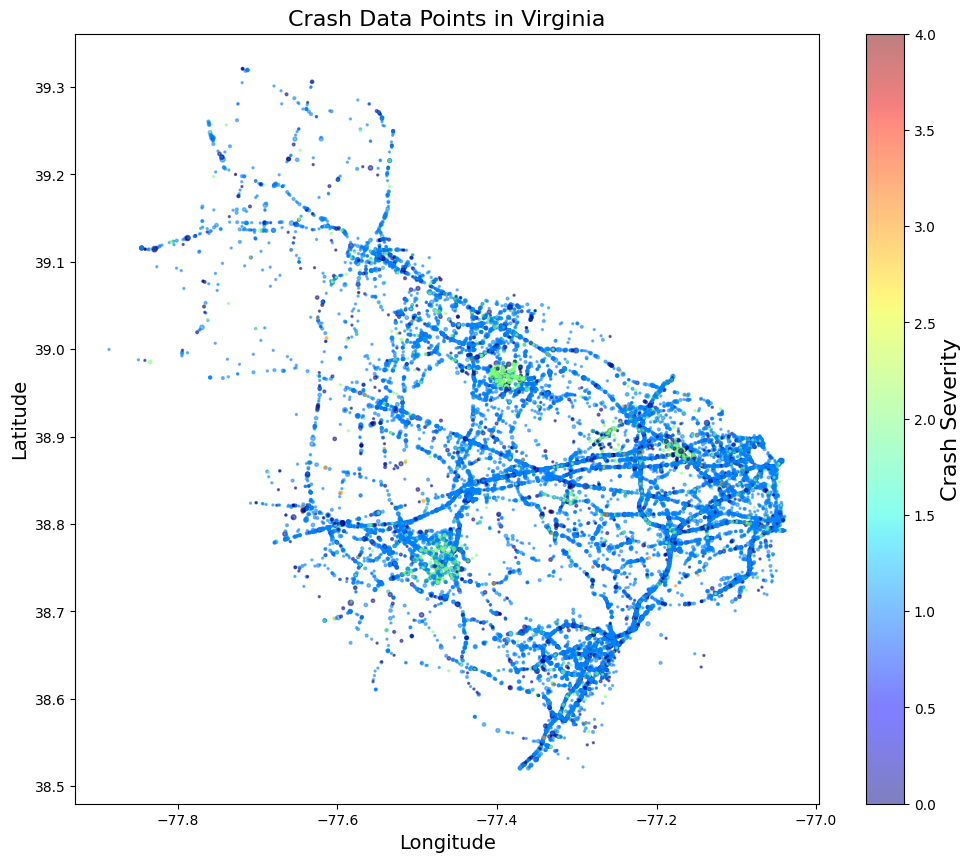

In [ ]:
%matplotlib inline
from pandas.plotting import scatter_matrix
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Plotting locations of the crashes, highlighting the number of people injured (by the size of the point) and crash severity (by the color)
crash_data = crashes_filtered
crash_data = crash_data.dropna(subset=['X', 'Y'])
plt.figure(figsize=(12, 10))

plt.scatter(
    crash_data['X'],
    crash_data['Y'],
    s=crash_data['PERSONS_INJURED'] * 2,
    c=crash_data['CRASH_SEVERITY'].astype('category').cat.codes,
    cmap=plt.get_cmap("jet"),
    alpha=0.5
)

plt.title('Crash Data Points in Virginia', fontsize=16)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
cbar = plt.colorbar()
cbar.set_label('Crash Severity', fontsize=16)
plt.show()


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


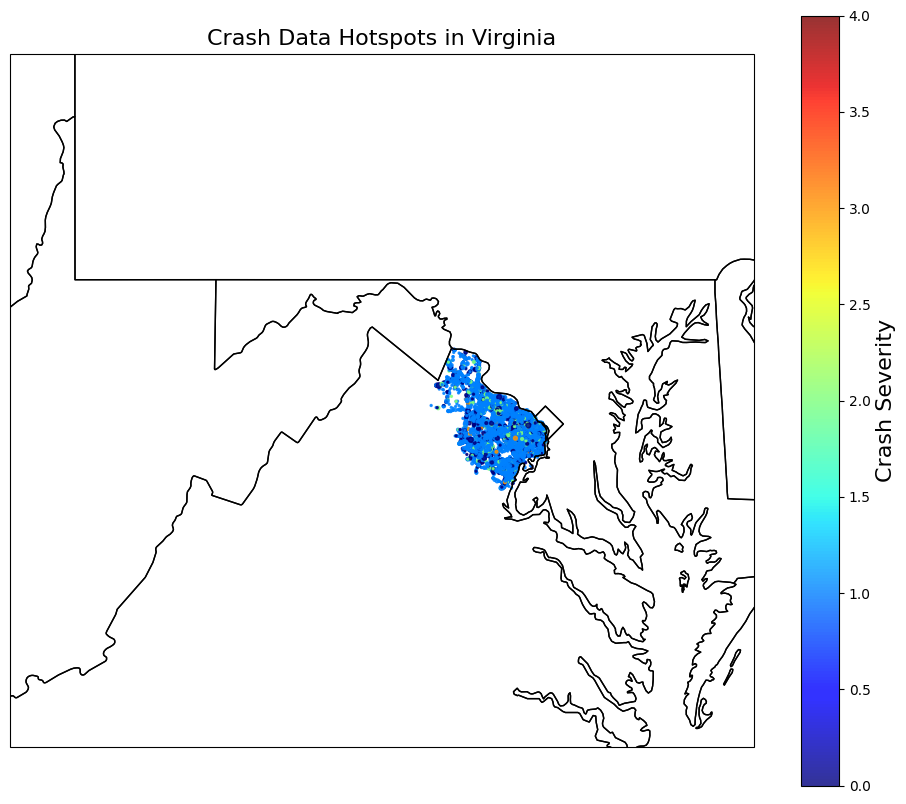

In [ ]:

#Plotting locations of the crashes, highlighting the number of people injured (by the size of the point) and the crash severity (by the color of the point)
#Plots points against a VA map
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.Mercator())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

ax.set_extent([-81, -75.5, 37, 41], crs=ccrs.PlateCarree())
ax.set_aspect('equal')

scatter = ax.scatter(
    crash_data['X'],
    crash_data['Y'],
    s=crash_data['PERSONS_INJURED'] * 2,
    c=crash_data['CRASH_SEVERITY'].astype('category').cat.codes,
    cmap=plt.get_cmap("jet"),
    alpha=0.8,
    transform=ccrs.PlateCarree()
)
plt.title('Crash Data Hotspots in Virginia', fontsize=16)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
cbar = plt.colorbar(scatter)
cbar.set_label('Crash Severity', fontsize=16)
plt.show()

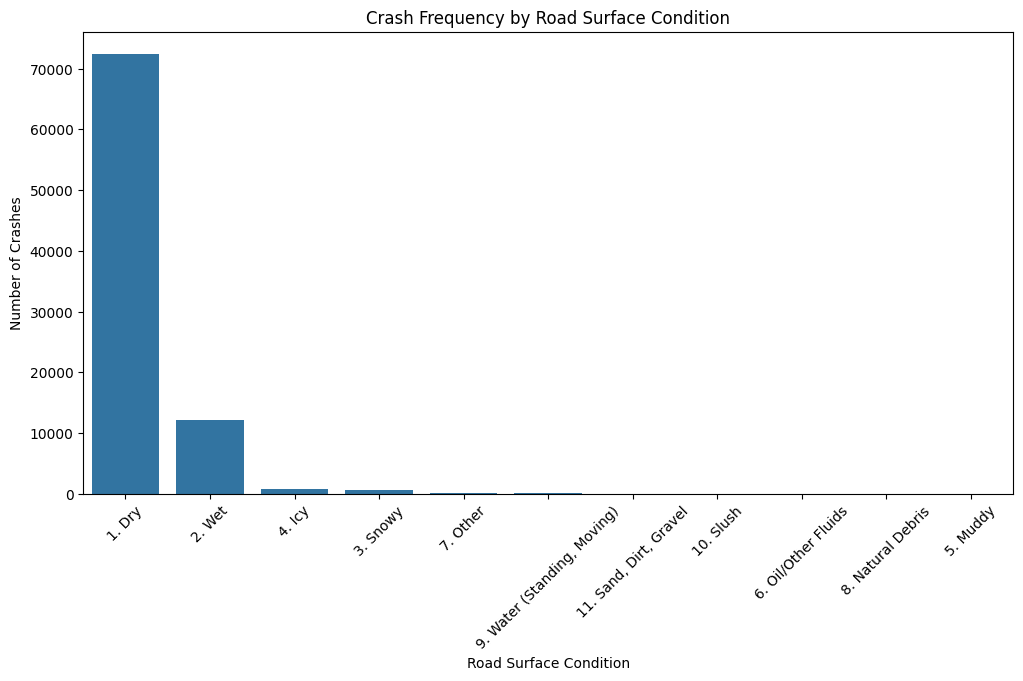

In [ ]:
# Ploting crash density by road surface condition
plt.figure(figsize=(12, 6))
sns.countplot(data=crashes_filtered, x='ROADWAY_SURFACE_COND', order=crashes_filtered['ROADWAY_SURFACE_COND'].value_counts().index)
plt.title("Crash Frequency by Road Surface Condition")
plt.xlabel("Road Surface Condition")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=45)
plt.show()

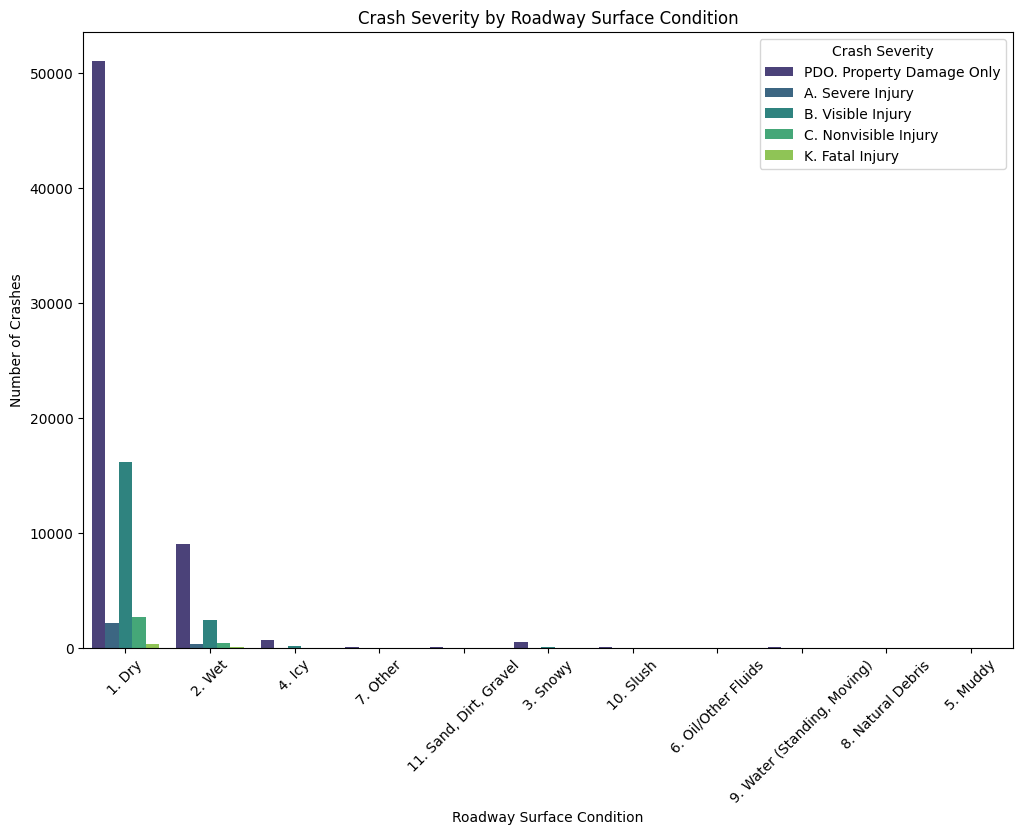

In [ ]:
#Comparison of road severity with varying road conditions
plt.figure(figsize=(12, 8))
sns.countplot(x='ROADWAY_SURFACE_COND', hue='CRASH_SEVERITY', data=crash_data, palette="viridis")
plt.title("Crash Severity by Roadway Surface Condition")
plt.xlabel("Roadway Surface Condition")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=45)
plt.legend(title='Crash Severity')
plt.show()

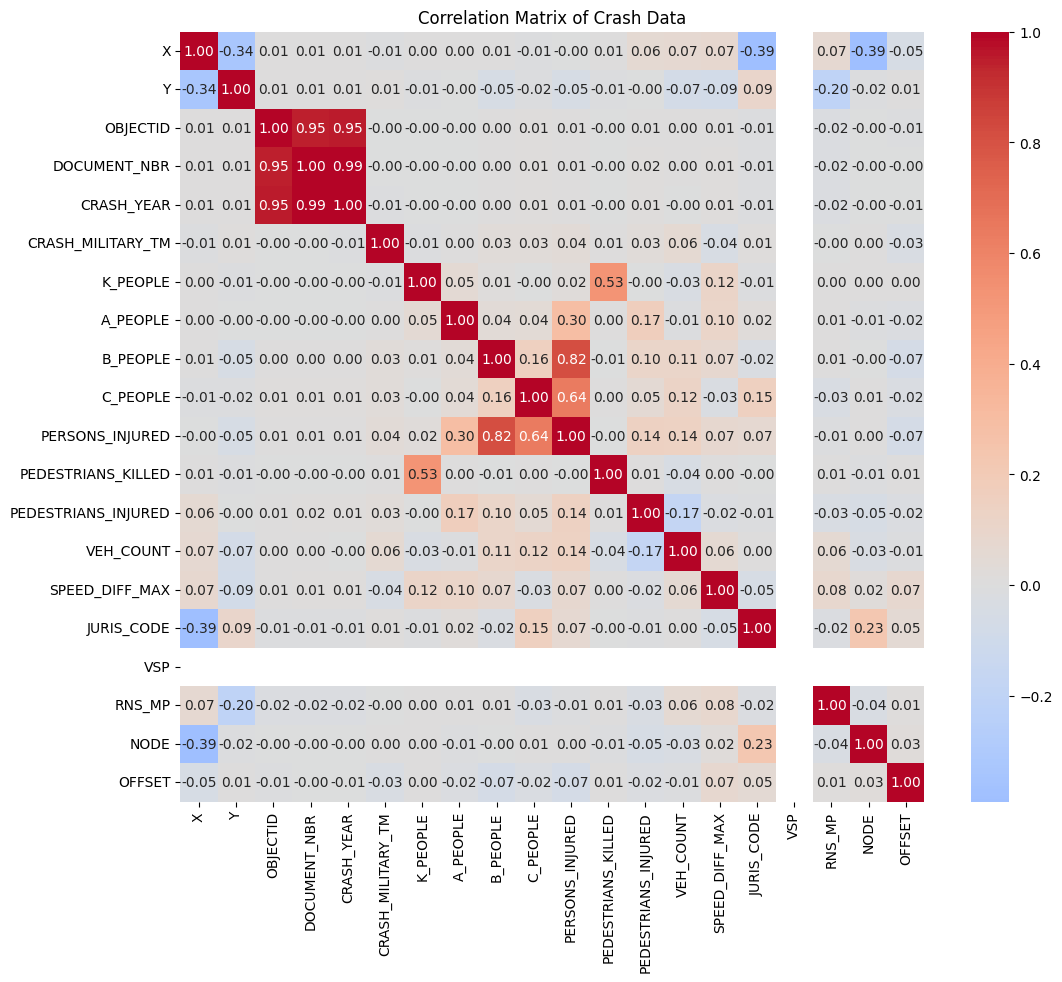

In [ ]:
#Correlation matrix heatmap
numeric_cols = crash_data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = crash_data[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Crash Data")
plt.show()

### did not include the first harmful event plotting from og colab since it was modifying the crash_data df directly

# feature engineering + data split

In [2]:
df = crashes_filtered.copy()

# Map severity to numerical values
severity_mapping = {
    "K. Fatal Injury": 4,
    "A. Severe Injury": 3,
    "B. Visible Injury": 2,
    "C. Nonvisible Injury": 1,
    "PDO. Property Damage Only": 0
}
df['CRASH_SEVERITY_NUMERIC'] = df['CRASH_SEVERITY'].map(severity_mapping)

# Define features to drop (including DUI-related features)
# we drop crash severity bc we have the numeric one!
features_to_drop = ['CRASH_YEAR', 'CRASH_MILITARY_TM', 'CRASH_SEVERITY',
                    'K_PEOPLE', 'A_PEOPLE', 'B_PEOPLE', 'C_PEOPLE',
                    'PERSONS_INJURED', 'PEDESTRIANS_KILLED', 'PEDESTRIANS_INJURED',
                    'VEH_COUNT', 'SPEED_NOTSPEED', 'SPEED_DIFF_MAX']

# also want to drop driver error features... as they do not contribute to bad road conditions
driver_error_features = ['DISTRACTED_NOTDISTRACTED', 'DROWSY_NOTDROWSY',
                         'DRUG_NODRUG','YOUNG_NOTYOUNG', 'SENIOR_NOTSENIOR',
                         'ALCOHOL_NOTALCOHOL', 'BELTED_UNBELTED']

# Drop the features
df = df.drop(columns=features_to_drop + driver_error_features)

# Define features for prediction
location_features = ['X', 'Y']
categorical_features = ['WEATHER_CONDITION', 'LIGHT_CONDITION', 'ROADWAY_SURFACE_COND', 'RELATION_TO_ROADWAY', 'ROADWAY_ALIGNMENT', 'ROADWAY_SURFACE_TYPE', 'ROADWAY_DEFECT', 'ROADWAY_DESCRIPTION', 'INTERSECTION_TYPE', 'TRAFFIC_CONTROL_TYPE', 'TRFC_CTRL_STATUS_TYPE', 'WORK_ZONE_RELATED', 'SCHOOL_ZONE', 'FIRST_HARMFUL_EVENT', 'FIRST_HARMFUL_EVENT_LOC', 'RD_TYPE', 'INTERSECTION_ANALYSIS', 'MAINLINE_YN', 'NIGHT', 'FUN', 'FAC', 'AREA_TYPE', 'SYSTEM']

In [3]:
# Prepare features and target variables
X = df[location_features + categorical_features]
y_severity = df['CRASH_SEVERITY_NUMERIC']
y_cause = df[['ROADWAY_DEFECT', 'LIGHT_CONDITION', 'ROADWAY_SURFACE_COND']]

# Split the data
X_train, X_test, y_severity_train, y_severity_test, y_cause_train, y_cause_test = train_test_split(X, y_severity, y_cause, test_size=0.2, random_state=42)

# Preprocessing pipelines

In [4]:
# preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, location_features),
        ('cat', categorical_transformer, categorical_features)
])

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Updated severity pipeline
severity_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=8,
        min_samples_leaf=2,
        max_features='sqrt',
        max_leaf_nodes=100,
        min_impurity_decrease=0.01,
        random_state=42
    ))
])

# Updated cause pipeline with SMOTE
cause_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=10,
        max_features='log2',
        class_weight='balanced',
        random_state=42
    )))
])

# Stratified K-Fold for cross-validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### cross validation here

In [6]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from collections import Counter
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

def cross_validate_severity(pipeline, X, y, cv):
    rmse_scores = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    return np.mean(rmse_scores), np.std(rmse_scores)

In [7]:
from sklearn.model_selection import KFold

def preprocess_for_smote(X):
    X_processed = X.copy()
    label_encoders = {}
    categorical_features = []

    for i, (col, dtype) in enumerate(X_processed.dtypes.items()):
        if dtype == 'object':
            le = LabelEncoder()
            X_processed[col] = le.fit_transform(X_processed[col])
            label_encoders[col] = le
            categorical_features.append(i)

    return X_processed, categorical_features, label_encoders

def cross_validate_cause(pipeline, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores = []

    X_processed, categorical_features, label_encoders = preprocess_for_smote(X)

    for train_index, test_index in kf.split(X_processed):
        X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply SMOTENC separately for each output
        y_resampled = []
        for i in range(y_train.shape[1]):
            try:
                smote = SMOTENC(categorical_features=categorical_features, random_state=42, k_neighbors=min(5, min(y_train.iloc[:, i].value_counts()) - 1))
                X_res, y_res = smote.fit_resample(X_train, y_train.iloc[:, i])

                # If SMOTE increased the sample size, use random undersampling to match original size
                if len(y_res) > len(y_train):
                    indices = np.random.choice(len(y_res), size=len(y_train), replace=False)
                    X_res, y_res = X_res.iloc[indices], y_res.iloc[indices]
            except ValueError:
                # If SMOTE fails, use original data for this output
                X_res, y_res = X_train, y_train.iloc[:, i]

            y_resampled.append(y_res)

        y_resampled = np.column_stack(y_resampled)

        # Fit the classifier
        classifier = pipeline.named_steps['classifier']
        classifier.fit(X_res, y_resampled)

        y_pred = classifier.predict(X_test)

        # Calculate F1 score for each output separately and then average
        f1_scores_fold = []
        for i in range(y_test.shape[1]):
            f1 = f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro')
            f1_scores_fold.append(f1)

        f1_scores.append(np.mean(f1_scores_fold))

    return np.mean(f1_scores), np.std(f1_scores)

# Perform cross-validation
severity_rmse, severity_rmse_std = cross_validate_severity(severity_pipeline, X, y_severity, skf)
cause_f1, cause_f1_std = cross_validate_cause(cause_pipeline, X, y_cause)

print(f"Severity Model RMSE: {severity_rmse:.4f} (+/- {severity_rmse_std:.4f})")
print(f"Cause Model Macro F1: {cause_f1:.4f} (+/- {cause_f1_std:.4f})")


Severity Model RMSE: 0.9462 (+/- 0.0015)
Cause Model Macro F1: 0.7948 (+/- 0.0171)


In [8]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [9]:
from imblearn.over_sampling import SMOTE
from scipy.sparse import issparse

def smote_multioutput(X, y):
    smote = SMOTE(random_state=42)
    max_samples = 0
    resampled_data = []

    # Convert X to dense if it's sparse
    if issparse(X):
        X = X.toarray()

    # Apply SMOTE for each target column
    for col in range(y.shape[1]):
        X_res, y_res = smote.fit_resample(X, y[:, col])
        max_samples = max(max_samples, len(X_res))
        resampled_data.append((X_res, y_res))

    # Align all outputs to have the same number of samples
    X_resampled = None
    y_resampled_list = []

    for X_res, y_res in resampled_data:
        if len(X_res) < max_samples:
            # Up-sample to match max_samples
            indices = np.random.choice(len(X_res), max_samples, replace=True)
            X_res = X_res[indices]
            y_res = y_res[indices]
        if X_resampled is None:
            X_resampled = X_res
        y_resampled_list.append(y_res)

    # Combine resampled targets
    y_resampled = np.column_stack(y_resampled_list)
    return X_resampled, y_resampled

# Convert y_cause_train to numpy array
y_cause_train = np.array(y_cause_train)

# Apply the updated SMOTE function
X_resampled, y_resampled = smote_multioutput(X_train_transformed, y_cause_train)

print(f"X_resampled shape: {X_resampled.shape}")
print(f"y_resampled shape: {y_resampled.shape}")


X_resampled shape: (673870, 194)
y_resampled shape: (673870, 3)


In [10]:
from sklearn.metrics import mean_squared_error, classification_report

cause_pipeline_no_smote = Pipeline([
    ('classifier', MultiOutputClassifier(RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=10,
        max_features='log2',
        class_weight='balanced',
        random_state=42
    )))
])

# Fit the pipeline on resampled data
cause_pipeline_no_smote.fit(X_resampled, y_resampled)

# Predictions
y_cause_pred = cause_pipeline_no_smote.predict(X_test_transformed)

# Debugging the prediction
print(f"y_cause_pred shape: {y_cause_pred.shape}")

# Predictions
y_severity_pred = severity_pipeline.predict(X_test)
# y_cause_pred = cause_pipeline.predict(X_test)

# Evaluate severity pipeline
severity_rmse_test = np.sqrt(mean_squared_error(y_severity_test, y_severity_pred))
print(f"Test RMSE for Severity Pipeline: {severity_rmse_test:.4f}")

# Evaluate cause pipeline
cause_f1_scores = []
for i in range(y_cause_test.shape[1]):
    f1 = f1_score(y_cause_test.iloc[:, i], y_cause_pred[:, i], average='macro')
    cause_f1_scores.append(f1)
mean_cause_f1 = np.mean(cause_f1_scores)
print(f"Test Macro F1 Score for Cause Pipeline: {mean_cause_f1:.4f}")

# Example prediction display
print("\nExample Predictions:")
print("Severity Predictions:", y_severity_pred[:5])
print("Cause Predictions:", y_cause_pred[:5])


y_cause_pred shape: (17294, 3)
Test RMSE for Severity Pipeline: 0.9416
Test Macro F1 Score for Cause Pipeline: 0.3671

Example Predictions:
Severity Predictions: [0.57349059 0.57349059 0.57349059 0.57349059 0.57349059]
Cause Predictions: [['1. No Defects' '2. Daylight' '7. Other']
 ['1. No Defects' '1. Dawn' '8. Natural Debris']
 ['7. Slick Pavement' '6. Darkness - Unknown Road Lighting' '4. Icy']
 ['1. No Defects' '5. Darkness - Road Not Lighted' '4. Icy']
 ['1. No Defects' '3. Dusk' '11. Sand, Dirt, Gravel']]


# post processing
### Here, we want to generate a report that identifies hotspots with predicted severity, what sort of defect was it, the light condition, or the roadway surface condition


Top Hotspots:
               X          Y  Predicted_Severity Primary_Suggested_Fix
12359 -77.209850  38.811468            0.749829    Fix Roadway Defect
8188  -77.312283  38.661046            0.749829    Fix Roadway Defect
9403  -77.282753  38.621151            0.749829    Fix Roadway Defect
16583 -77.056358  38.860850            0.749829    Fix Roadway Defect
16585 -77.056323  38.813404            0.749829    Fix Roadway Defect
16586 -77.056319  38.780531            0.749829    Fix Roadway Defect
13993 -77.159591  38.708850            0.749829    Fix Roadway Defect
12329 -77.210327  38.923946            0.749829    Fix Roadway Defect
9412  -77.282545  38.620780            0.749829    Fix Roadway Defect
4684  -77.430623  38.827776            0.749829    Fix Roadway Defect


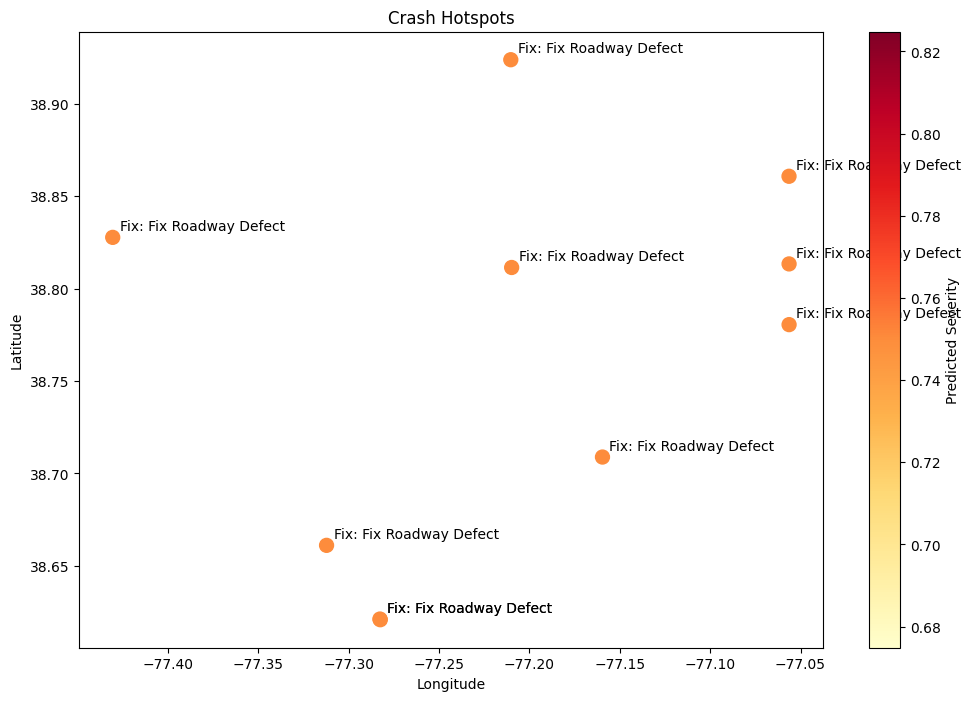

In [11]:
def identify_hotspots(X_original, severity_predictions, cause_predictions, top_n=10):
    # Create DataFrame with predictions
    df_hotspots = pd.DataFrame({
        'X': X_original['X'].values,
        'Y': X_original['Y'].values,
        'Predicted_Severity': severity_predictions,
        'Predicted_Cause_Roadway_Defect': cause_predictions[:, 0],
        'Predicted_Cause_Light_Condition': cause_predictions[:, 1],
        'Predicted_Cause_Roadway_Surface_Cond': cause_predictions[:, 2]
    })

    # Group by location and aggregate
    df_grouped = df_hotspots.groupby(['X', 'Y']).agg({
        'Predicted_Severity': 'mean',  # Average severity at location
        'Predicted_Cause_Roadway_Defect': lambda x: x.mode().iloc[0] if not x.mode().empty else 'UNKNOWN',
        'Predicted_Cause_Light_Condition': lambda x: x.mode().iloc[0] if not x.mode().empty else 'UNKNOWN',
        'Predicted_Cause_Roadway_Surface_Cond': lambda x: x.mode().iloc[0] if not x.mode().empty else 'UNKNOWN'
    }).reset_index()

    # Sort by severity and get top N hotspots
    df_hotspots = df_grouped.sort_values('Predicted_Severity', ascending=False).head(top_n)

    # Determine primary suggested fix
    df_hotspots['Primary_Suggested_Fix'] = df_hotspots.apply(lambda row:
        'Fix Roadway Defect' if row['Predicted_Cause_Roadway_Defect'] != 'NONE' else
        'Improve Lighting' if row['Predicted_Cause_Light_Condition'] in ['DARK - NOT LIGHTED', 'DARK - LIGHTED'] else
        'Improve Road Surface' if row['Predicted_Cause_Roadway_Surface_Cond'] != 'DRY' else
        'Further Investigation Needed', axis=1)

    return df_hotspots[['X', 'Y', 'Predicted_Severity', 'Primary_Suggested_Fix']]

# Get hotspots
hotspots = identify_hotspots(X_test, y_severity_pred, y_cause_pred)
print("\nTop Hotspots:")
print(hotspots)

# Visualize hotspots
plt.figure(figsize=(12, 8))
plt.scatter(hotspots['X'], hotspots['Y'], c=hotspots['Predicted_Severity'], cmap='YlOrRd', s=100)
plt.colorbar(label='Predicted Severity')
plt.title('Crash Hotspots')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add annotations for suggested fixes
for i, row in hotspots.iterrows():
    plt.annotate(f"Fix: {row['Primary_Suggested_Fix']}", (row['X'], row['Y']), xytext=(5, 5), textcoords='offset points')

plt.show()


In [12]:
pip install folium

In [13]:
import folium
from folium.plugins import MarkerCluster

def plot_hotspots_on_map(hotspots, map_center=(38.8462, -77.3064), zoom_start=10):
    """
    Plot hotspots on an interactive map using folium.

    Args:
        hotspots (pd.DataFrame): DataFrame with columns 'X', 'Y', 'Predicted_Severity', and 'Primary_Suggested_Fix'.
        map_center (tuple): Latitude and longitude to center the map.
        zoom_start (int): Initial zoom level for the map.

    Returns:
        folium.Map: Folium map object with plotted hotspots.
    """
    # Create a folium map centered on Northern Virginia
    m = folium.Map(location=map_center, zoom_start=zoom_start, tiles='cartodbpositron')

    # Add a marker cluster for better visualization of multiple points
    marker_cluster = MarkerCluster().add_to(m)

    # Add hotspots to the map
    for _, row in hotspots.iterrows():
        location = (row['Y'], row['X'])  # folium uses (latitude, longitude)
        print(f"Plotting location: {location}, Severity: {row['Predicted_Severity']}")  # Debugging
        popup = f"""
        <b>Severity:</b> {row['Predicted_Severity']}<br>
        <b>Fix Suggestion:</b> {row['Primary_Suggested_Fix']}
        """
        color = 'red' if row['Predicted_Severity'] > 0.6 else 'orange' if row['Predicted_Severity'] > 0.3 else 'green'
        folium.CircleMarker(
            location=location,
            radius=15,  # Adjust radius for better visibility
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=folium.Popup(popup, max_width=300)
        ).add_to(marker_cluster)

    return m

# Generate the map
nova_map = plot_hotspots_on_map(hotspots)  # Removed CRS argument
nova_map.save("northern_virginia_hotspots.html")
nova_map


Plotting location: (38.8114683570001, -77.209849506), Severity: 0.7498289048019933
Plotting location: (38.6610461170001, -77.312282763), Severity: 0.7498289048019933
Plotting location: (38.6211514600001, -77.28275254), Severity: 0.7498289048019933
Plotting location: (38.8608504590001, -77.056358406), Severity: 0.7498289048019933
Plotting location: (38.8134042230001, -77.056323434), Severity: 0.7498289048019933
Plotting location: (38.7805311160001, -77.056319351), Severity: 0.7498289048019933
Plotting location: (38.708849709, -77.1595907449999), Severity: 0.7498289048019933
Plotting location: (38.923945691, -77.2103274839999), Severity: 0.7498289048019933
Plotting location: (38.620780053, -77.2825448519999), Severity: 0.7498289048019933
Plotting location: (38.8277760500001, -77.43062263), Severity: 0.7498289048019933


### export to csv for further analysis!

In [16]:
hotspots.to_csv('hotspots.csv', index=False)
from google.colab import files
files.download('hotspots.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>